In [57]:
import pandas as pd
import numpy as np
import glob
import json
import cv2

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageColor

| 分类类别名称 | 解释                                                         |
| ------------ | ------------------------------------------------------------ |
| title        | 文章的主标题，一般只在首页出现                               |
| author       | 文章的作者名字                                               |
| mail         | 文章作者的联系方式                                           |
| affiliation  | 文章作者的所属机构                                           |
| section      | 章节标题                                                     |
| fstline      | 段落的首行文本                                               |
| paraline     | 段落中的其他行文本                                           |
| table        | 表格区域                                                     |
| figure       | 图像区域                                                     |
| caption      | 图像或者表格的描述文本                                       |
| equality     | 独立的公式区域                                               |
| footer       | 页脚，例如页数、期刊名称等，位于页面正下方                   |
| header       | 页眉，例如页数、论文标题等，位于页面正上方                   |
| footnote     | 文章内容的注释，例如链接、作者信息等，位于正文区域的左下方或者右下方 |

In [18]:
train_json = glob.glob('./学术文档要素分类挑战赛公开数据/train-anno/*/*.json')
train_img = glob.glob('./学术文档要素分类挑战赛公开数据/train-image/*/*.png')

test_json = glob.glob('./学术文档要素分类挑战赛公开数据/test-anno/*/*.json')
test_img = glob.glob('./学术文档要素分类挑战赛公开数据/test-image/*/*.png')

train_json.sort()
train_img.sort()

test_json.sort()
test_img.sort()

In [22]:
train_json[:10]

['./学术文档要素分类挑战赛公开数据/train-anno/0/0.json',
 './学术文档要素分类挑战赛公开数据/train-anno/0/1.json',
 './学术文档要素分类挑战赛公开数据/train-anno/0/2.json',
 './学术文档要素分类挑战赛公开数据/train-anno/0/3.json',
 './学术文档要素分类挑战赛公开数据/train-anno/0/4.json',
 './学术文档要素分类挑战赛公开数据/train-anno/0/5.json',
 './学术文档要素分类挑战赛公开数据/train-anno/0/6.json',
 './学术文档要素分类挑战赛公开数据/train-anno/0/7.json',
 './学术文档要素分类挑战赛公开数据/train-anno/0/8.json',
 './学术文档要素分类挑战赛公开数据/train-anno/1/0.json']

In [81]:
colors_list = list(ImageColor.colormap.keys())[10:]

In [72]:
class_names = '''title
author
mail
affiliation
section
fstline
paraline
table
figure
caption
equality
footer
header
footnote'''

In [76]:
class_names.split('\n').index(box['class'])

6

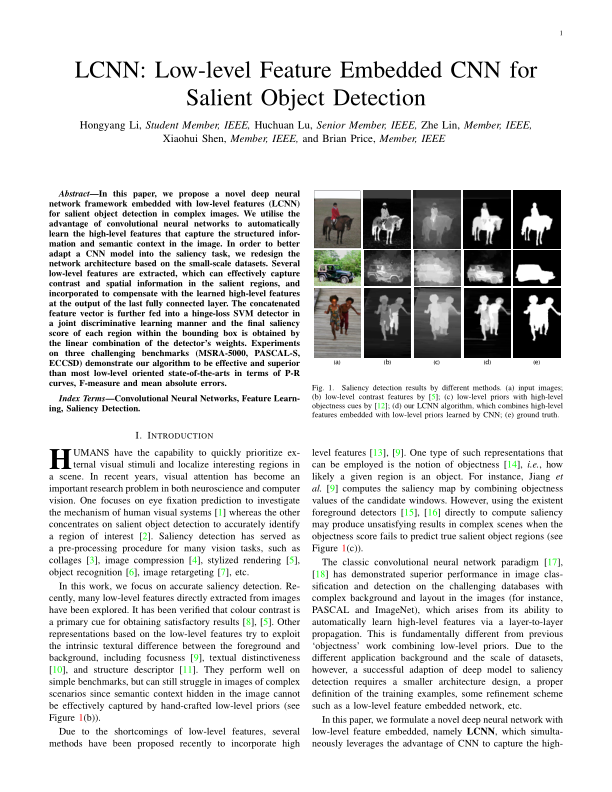

In [32]:
img = Image.open(train_img[0])
img

In [82]:
anns = json.load(open(train_json[0]))

In [83]:
img1 = ImageDraw.Draw(img)
for box in anns:
    img1.rectangle(box['box'],outline = colors_list[class_names.split('\n').index(box['class'])])

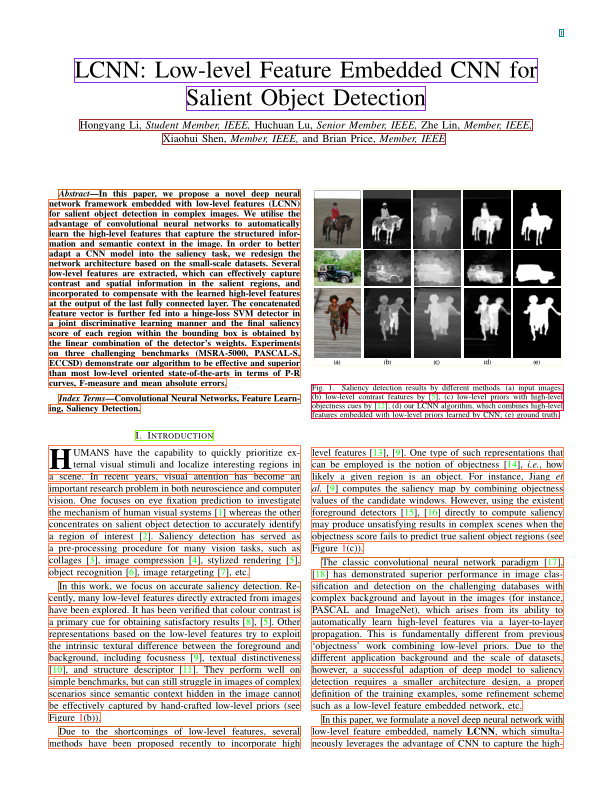

In [84]:
img1._image

In [155]:
features = []
lables = []

for image_path, ann_path in zip(train_img, train_json):
    img = Image.open(image_path)
    anns = json.load(open(ann_path))
    for ann in anns[:]:
        feat = [
            int(ann_path.split('/')[-1][:-5]),
            ann['box'][2] - ann['box'][0],
            ann['box'][3] - ann['box'][1],
            (ann['box'][2] - ann['box'][0]) / (1 + ann['box'][3] - ann['box'][1]),
            ann['box'][0] / img.size[0], ann['box'][2] / img.size[0],
            ann['box'][1] / img.size[1], ann['box'][2] / img.size[1],
            (ann['box'][0] + ann['box'][2]) / 2 / img.size[0],
            (ann['box'][1] + ann['box'][2]) / 2 / img.size[1],
            len(ann['text']), ann['text'].count(' '), ann['text'].count('.'),
            ann['text'].islower(), ann['text'].isupper(), ann['text'].istitle(),
            ann['text'].endswith('.'), ann['text'].endswith('?'),
            ann['text'][1:].islower(), ann['text'][1:].isupper(), ann['text'][1:].istitle(),
            (ann['box'][2] - ann['box'][0]) / (len(ann['text']) + 1)
        ]
        features.append(feat)
        lables.append(ann['class'])

In [156]:
features = np.array(features)
lables = np.array(lables)

In [165]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report

In [166]:
pred = cross_val_predict(
    LGBMClassifier(),
    features,
    lables
)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3096
[LightGBM] [Info] Number of data points in the train set: 253801, number of used features: 22
[LightGBM] [Info] Start training from score -5.376134
[LightGBM] [Info] Start training from score -6.019437
[LightGBM] [Info] Start training from score -3.301709
[LightGBM] [Info] Start training from score -3.455360
[LightGBM] [Info] Start training from score -4.669870
[LightGBM] [Info] Start training from score -4.457121
[LightGBM] [Info] Start training from score -4.862077
[LightGBM] [Info] Start training from score -1.849648
[LightGBM] [Info] Start training from score -4.334479
[LightGBM] [Info] Start training from score -6.717458
[LightGBM] [Info] Start training from score -0.365322
[LightGBM] [Info] Start training from score -3.73

In [167]:
print(classification_report(lables, pred))

              precision    recall  f1-score   support

 affiliation       0.34      0.49      0.40      1468
      author       0.23      0.34      0.27       772
     caption       0.40      0.24      0.30     11681
    equation       0.82      0.82      0.82     10018
      figure       0.59      0.73      0.65      2974
      footer       0.79      0.81      0.80      3678
    footnote       0.40      0.51      0.45      2454
     fstline       0.67      0.57      0.61     49901
      header       0.80      0.77      0.79      4159
        mail       0.17      0.29      0.22       384
    paraline       0.87      0.90      0.89    220164
     section       0.66      0.68      0.67      7579
       table       0.40      0.46      0.43      1118
       title       0.48      0.72      0.57       902

    accuracy                           0.80    317252
   macro avg       0.54      0.59      0.56    317252
weighted avg       0.80      0.80      0.80    317252



In [168]:
test_features = []

for image_path, ann_path in zip(test_img, test_json):
    img = Image.open(image_path)
    anns = json.load(open(ann_path))
    for ann in anns[:]:
        feat = [
            int(ann_path.split('/')[-1][:-5]),
            ann['box'][2] - ann['box'][0],
            ann['box'][3] - ann['box'][1],
            (ann['box'][2] - ann['box'][0]) / (1 + ann['box'][3] - ann['box'][1]),
            ann['box'][0] / img.size[0], ann['box'][2] / img.size[0],
            ann['box'][1] / img.size[1], ann['box'][2] / img.size[1],
            (ann['box'][0] + ann['box'][2]) / 2 / img.size[0],
            (ann['box'][1] + ann['box'][2]) / 2 / img.size[1],
            len(ann['text']), ann['text'].count(' '), ann['text'].count('.'),
            ann['text'].islower(), ann['text'].isupper(), ann['text'].istitle(),
            ann['text'].endswith('.'), ann['text'].endswith('?'),
            ann['text'][1:].islower(), ann['text'][1:].isupper(), ann['text'][1:].istitle(),
            (ann['box'][2] - ann['box'][0]) / (len(ann['text']) + 1)
        ]
        test_features.append(feat)

In [170]:
test_features = np.array(test_features)

model = LGBMClassifier()
model.fit(features, lables)
test_pred = model.predict(test_features)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007743 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3106
[LightGBM] [Info] Number of data points in the train set: 317252, number of used features: 22
[LightGBM] [Info] Start training from score -5.375795
[LightGBM] [Info] Start training from score -6.018467
[LightGBM] [Info] Start training from score -3.301733
[LightGBM] [Info] Start training from score -3.455313
[LightGBM] [Info] Start training from score -4.669789
[LightGBM] [Info] Start training from score -4.457327
[LightGBM] [Info] Start training from score -4.861977
[LightGBM] [Info] Start training from score -1.849655
[LightGBM] [Info] Start training from score -4.334422
[LightGBM] [Info] Start training from score -6.716809
[LightGBM] [Info] Start training from score -0.365324
[LightGBM] [Info] Start training from score -3.73

In [197]:
import os
os.mkdir('submit')

In [198]:
index = 0
for image_path, ann_path in zip(test_img, test_json):
    doc_id, json_id = ann_path.split('/')[-2:]
    os.makedirs(f'submit/{doc_id}', exist_ok=True)
    anns = json.load(open(ann_path))
    for idx in range(len(anns)):
        anns[idx]['class'] = test_pred[index]
        index += 1

    with open(f'submit/{doc_id}/{json_id}', 'w') as up:
        json.dump(anns, up, indent=2)

In [199]:
!zip -r submit.zip submit > /dev/null